In [1]:
%%javascript
$(document).ready(() => {
    // Удаление данного блока кода с конечного результата.
    $('div.code_cell').first().css('display', 'none');

    // Включение автоматического переноса слов в параграфе.
    $('div.text_cell p').css('hyphens', 'auto');

    // Включение растягивания текста на всю доступную длину.
    $('div.text_cell p').css('text-align', 'justify');
});

<IPython.core.display.Javascript object>

<h3><b>Лабораторная работа №3: Переобучение и регуляризация</b></h3>

<p lang="ru">Переобучение — это результат чрезмерной подгонки параметров модели к зависимостям, содержащимся в обучающем множестве. Если происходит переобучение, то модель не приобретает способности к обобщению — возможности распространять обнаруженные на обучающем множестве зависимости и закономерности на новые данные. Такая модель на практике оказывается бесполезной, даже если её ошибка обучения мала. Данную проблему решают с помощью регуляризации. Регуляризация в машинном обучении является методом добавления некоторых дополнительных ограничений к условию с целью решить некорректно поставленную задачу или предотвратить переобучение.</p>

In [2]:
%autosave 300

Autosaving every 300 seconds


In [3]:
import warnings

# Игнорирование некоторых оповещающих сообщений библиотек.
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
import numpy as np

In [5]:
# Импортирование дополнительного алгоритма для оптимизации модели.
from scipy.optimize import fmin_cg

In [6]:
# Импортирование функции для чтения MATLAB файлов.
from scipy.io import loadmat

In [7]:
# Импортирование библиотеки для работы с графиками.
from matplotlib import pyplot
%matplotlib inline

In [8]:
# Установка начального значения для генератора случайных чисел.
# Данное действие требуется для воспроизведения результатов опыта.
np.random.seed(0)

In [9]:
def extend_values(values):
    # Добавление единичного столбца в качестве значений смещения.
    return np.c_[(np.ones(values.shape[0]), values)]

<p lang="ru"><b>Пункт №1:&nbsp;</b>Загрузка первого предоставленного набора данных <tt>ex3data1.mat</tt> при помощи внешней библиотеки scipy. Текущий набор данных содержит некоторую информацию об изменениях уровня воды и объеме воды, вытекающего из дамбы.</p>

In [10]:
data = loadmat('./datasets/ex3data1.mat')

In [11]:
# Создание тренировочной выборки.
train_x = data['X']
train_y = data['y'].ravel()

# Создание валидационной выборки.
valid_x = data['Xval']
valid_y = data['yval'].ravel()

# Создание контрольной выборки.
tests_x = data['Xtest']
tests_y = data['ytest'].ravel()

<p lang="ru"><b>Пункт №2:&nbsp;</b>Построение графика зависимости уровня воды от вытекающего объема воды из дамбы. Всякую зависимость между двумя типами данных хорошо показывает диаграмма разброса значений. Ко всему прочему, с помощью этой диаграммы можно определить корреляцию между каким-либо параметром качества и влияющим на него фактором.</p>

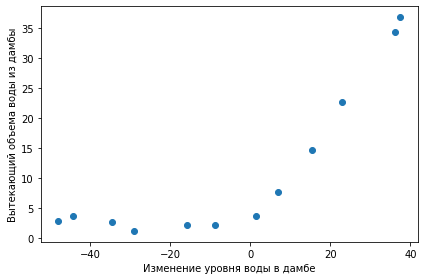

In [12]:
# Построение точечной диаграммы разброса данных.
pyplot.scatter(train_x, train_y)

# Настройка координатных осей графика.
pyplot.xlabel('Изменение уровня воды в дамбе')
pyplot.ylabel('Вытекающий объема воды из дамбы')

# Настройка отображения.
pyplot.tight_layout()

# Отображение графика.
pyplot.show()

<p lang="ru"><b>Пункт №3:&nbsp;</b>Реализация функции стоимости модели для набора данных <tt>ex3data1.mat</tt> при помощи внешней библиотеки numpy. Данная функция выражает меру количества ошибок, которые рассматриваемая модель делает на наборе данных. Хоть и существуют различные функции стоимости, все они вычисляют расстояние между предсказанным и фактическим значением.</p>

In [13]:
def calc_cost(w, x, y):
    # Функция вычисления значения стоимости математической модели.
    return np.sum(np.square(x.dot(w) - y)) / (2 * y.shape[0])

In [14]:
def calc_grad(w, x, y):
    # Функция вычисления градиента функции стоимости.
    return x.T.dot(x.dot(w) - y) / y.shape[0]

<p lang="ru"><b>Пункт №4:&nbsp;</b>Реализация алгоритма градиентного спуска с модификацией adam для выбора оптимальных параметров математической модели. Данная модификация стандартного алгоритма без труда справляется с проблемой впадин градиента и не так сильно подвержена застреванию в локальных минимумах функции, тем самым оптимизация происходит намного быстрее.</p>

In [15]:
def fmin_adam(x0, fprime, args=(), alpha=0.05, beta_1=0.9, beta_2=0.999, eps=1e-6, eps_min=1e-8):
    # Инициализация начального приближения модели.
    xx = x0[:]
    xi = x0[:]

    # Инициализация скользящих средних.
    m_t = np.zeros(xx.shape[0])
    v_t = np.zeros(xx.shape[0])

    funcalls = 1
    while True:
        # Вычисление значения градиента в данной точке.
        grad = fprime(xx, *args)

        # Обновление скользящих средних градиентов.
        m_t = beta_1 * m_t + (1 - beta_1) * grad
        v_t = beta_2 * v_t + (1 - beta_2) * np.square(grad)

        # Вычисление коррекции расчета алгоритма.
        mhat_t = m_t / (1 - (np.power(beta_1, funcalls)))
        vhat_t = v_t / (1 - (np.power(beta_2, funcalls)))

        # Пересчет значений параметров модели.
        xi = xx - (alpha * mhat_t) / (np.sqrt(vhat_t) + eps_min)

        # Условие остановки алгоритма оптимизации.
        if np.sum(abs(xi - xx)) <= eps:
            break

        funcalls += 1
        xx = xi  # Обновите значения параметров на новые.

    return xx.ravel()

In [16]:
def fit(x, y):
    # Запуск оптимизации математической модели.
    return fmin_adam(x0=np.zeros(x.shape[1]), fprime=calc_grad, args=(x, y))

<p lang="ru"><b>Пункт №5:&nbsp;</b>Построение полученной модели совместно с графиком зависимости уровня воды от вытекающего объема воды из дамбы. Данное действие необходимо для визуальной оценки корректности математической модели к обобщению данных.</p>

In [17]:
%%time

# Запуск оптимизации математической модели.
thetas = fit(extend_values(train_x), train_y)

CPU times: user 107 ms, sys: 997 µs, total: 108 ms
Wall time: 157 ms


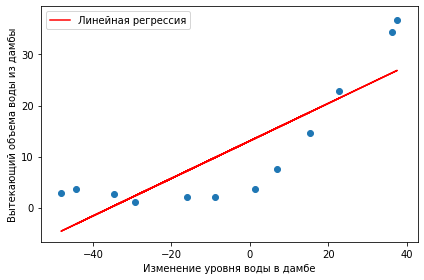

In [18]:
# Построение разделяющей линии полученной математической модели.
pyplot.plot(train_x, extend_values(train_x).dot(thetas), label='Линейная регрессия', color='r')

# Настройка координатных осей графика.
pyplot.legend(loc='best')

# Построение точечной диаграммы разброса данных.
pyplot.scatter(train_x, train_y)

# Настройка координатных осей графика.
pyplot.xlabel('Изменение уровня воды в дамбе')
pyplot.ylabel('Вытекающий объема воды из дамбы')

# Настройка отображения.
pyplot.tight_layout()

# Отображение графика.
pyplot.show()

<p lang="ru"><b>Пункт №6:&nbsp;</b>Построение графика процесса обучения для обучающей и валидационной выборки. Кривая обучения — это графическое представление того, как изменение меры обученности зависит от определенной единицы измерения опыта. Данное действие необходимо для визуальной оценки корректности обучения математической модели. После построения графиков процесса обучения можно заметить, что тренировка модели не приносит результатов, т. к. значение стоимости на валидационной выборке не уменьшается.</p>

In [19]:
def draw_process(cost_train, cost_valid):
    # Построение графика процесса обучения исходной модели.
    pyplot.plot(cost_train[1:], label='Обучающая выборка', marker='o')
    pyplot.plot(cost_valid[1:], label='Валидационная выборка', marker='*')

    # Настройка координатных осей графика.
    pyplot.xlabel('Количество обучающих примеров')
    pyplot.ylabel('Значение стоимости')

    # Настройка координатных осей графика.
    pyplot.legend(loc='best')

    # Настройка отображения.
    pyplot.tight_layout()

    # Отображение графика.
    pyplot.show()

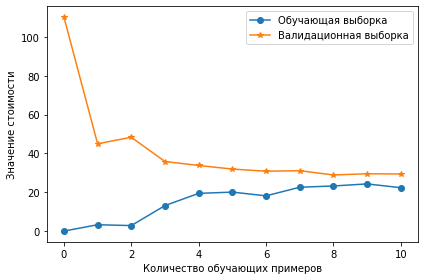

In [20]:
# Создание контейнеров для накопления значений стоимостей.
train_cost = np.zeros(train_y.shape[0])
valid_cost = np.zeros(train_y.shape[0])

# Запуск оптимизации математической модели.
for i in range(1, train_y.shape[0]):
    temp = fit(extend_values(train_x)[0:i+1, :], train_y[0:i+1])

    # Вычисление и сохранение стоимости на тестируемой и валидационной выборке.
    train_cost[i] = calc_cost(temp, extend_values(train_x)[0:i+1, :], train_y[0:i+1])
    valid_cost[i] = calc_cost(temp, extend_values(valid_x), valid_y)

# Построение процесса обучения математической модели.
draw_process(train_cost, valid_cost)

In [21]:
# Вычисление значения стоимости обученной математической модели.
print('Значение стоимости:', calc_cost(thetas, extend_values(valid_x), valid_y))

Значение стоимости: 29.433878918718456


<p lang="ru"><b>Пункт №7:&nbsp;</b>Реализация функции добавления нескольких новых признаков в обучающую выборку. Данное действие позволит создать дополнительные признаки, которые помогут обучить модель обобщать нелинейные данные намного лучше.</p>

In [22]:
def create_feature_map(x, degree=8):
    # Создание вектора для накопления карты признаков.
    out_map = np.ones((x.shape[0], degree))

    for i in range(0, degree):
        # Вычисление нового признака.
        out_map[:, i] = np.power(x.ravel(), i + 1)

    return out_map

In [23]:
# Расширение признаков тренировочной выборки.
train_poly = create_feature_map(train_x)

# Расширение признаков валидационной выборки.
valid_poly = create_feature_map(valid_x)

# Расширение признаков контрольной выборки.
tests_poly = create_feature_map(tests_x)

<p lang="ru"><b>Пункт №8:&nbsp;</b>Нормализация признаков данных. Нормализация предполагает замену номинальных признаков так, чтобы каждый из них лежал в диапазоне от нуля до единицы. Это необходимо поскольку в данной задаче будет использован полином высокой степени.</p>

In [24]:
class StandartScaler:

    def __init__(self, data):
        # Вычисление мат. ожидания и среднего отклонения выборки.
        self.mean = data.mean(axis=0)
        self.std = data.std(axis=0, ddof=1)

    def transform(self, data):
        # Произведение стандартной нормализации.
        return (data - self.mean) / self.std

In [25]:
scaler = StandartScaler(train_poly)

In [26]:
# Нормализация признаков тренировочной выборки.
train_norm = extend_values(scaler.transform(train_poly))

# Нормализация признаков валидационной выборки.
valid_norm = extend_values(scaler.transform(valid_poly))

# Нормализация признаков контрольной выборки.
tests_norm = extend_values(scaler.transform(tests_poly))

<p lang="ru"><b>Пункт №9:&nbsp;</b>Обучение математической модели и построение графика ее процесса обучения для обучающей и валидационной выборки. Кривая обучения — это графическое представление того, как изменение меры обученности зависит от определенной единицы измерения опыта. Данное действие необходимо для визуальной оценки корректности обучения математической модели.</p>

In [27]:
%%time

# Запуск оптимизации математической модели.
thetas = fit(train_norm, train_y)

CPU times: user 22.1 s, sys: 109 ms, total: 22.2 s
Wall time: 24.2 s


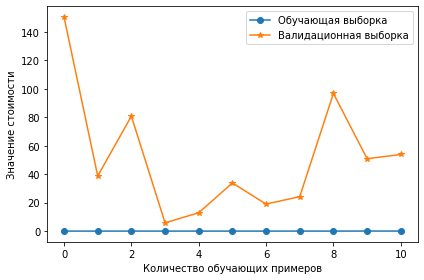

In [28]:
# Создание контейнеров для накопления значений стоимостей.
train_cost = np.zeros(train_y.shape[0])
valid_cost = np.zeros(train_y.shape[0])

# Запуск оптимизации математической модели.
for i in range(1, train_y.shape[0]):
    temp = fit(extend_values(train_norm)[0:i+1, :], train_y[0:i+1])

    # Вычисление и сохранение стоимости на тестируемой и валидационной выборке.
    train_cost[i] = calc_cost(temp, extend_values(train_norm)[0:i+1, :], train_y[0:i+1])
    valid_cost[i] = calc_cost(temp, extend_values(valid_norm), valid_y)

# Построение процесса обучения математической модели.
draw_process(train_cost, valid_cost)

<p lang="ru"><b>Пункт №10:&nbsp;</b>Построение полученной модели совместно с графиком зависимости уровня воды от вытекающего объема воды из дамбы. Данное действие необходимо для визуальной оценки корректности математической модели к обобщению данных. После построения графиков математической модели можно сделать вывод, что модель сильно переобучена, т. к. разделяющая линия охватывает все точки данных, а значение стоимости сильно выросло.</p>

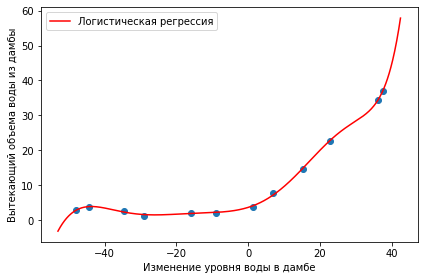

In [29]:
x = np.linspace(train_x.min()-5, train_x.max()+5, 1000)
x_poly = extend_values(scaler.transform(create_feature_map(x)))

# Построение разделяющей линии полученной модели.
pyplot.plot(x, x_poly.dot(thetas), label='Логистическая регрессия', color='r')

# Построение легенды графика.
pyplot.legend(loc='best')

# Построение точечной диаграммы разброса данных.
pyplot.scatter(train_x, train_y)

# Настройка координатных осей графика.
pyplot.xlabel('Изменение уровня воды в дамбе')
pyplot.ylabel('Вытекающий объема воды из дамбы')

# Настройка отображения.
pyplot.tight_layout()

# Отображение графика.
pyplot.show()

In [30]:
# Вычисление значения стоимости обученной математической модели.
print('Значение стоимости:', calc_cost(thetas, valid_norm, valid_y))

Значение стоимости: 53.87387295600625


<p lang="ru"><b>Пункт №11:&nbsp;</b>Реализация гребневой регуляризации для линейной регрессии и обучение ее на расширенном наборе признаков исходных данных. Регуляризация подразумевает собой добавление некоторых дополнительных ограничений к условию с целью решить некорректно поставленную задачу или предотвратить переобучение. Например, это могут быть ограничения гладкости результирующей функции или ограничения по норме векторного пространства.</p>

In [31]:
def calc_cost(w, x, y, l2=0.0):
    # Функция вычисления значения стоимости математической модели.
    return (np.sum(np.square(x.dot(w) - y)) + np.sum(l2 * np.square(w[1:]))) / (2 * y.shape[0])

In [32]:
def calc_grad(w, x, y, l2=0.0):
    reg = l2 * w
    reg[0] = 0  # Не штрафуем коэффициент смещения.

    # Функция вычисления градиента функции стоимости.
    return (x.T.dot(x.dot(w) - y) + reg) / y.shape[0]

In [33]:
def fit(x, y, l2=0.0):
    # Инициализация начальных параметров модели.
    prime = np.zeros(x.shape[1])

    # Запуск оптимизации математической модели.
    return fmin_cg(f=calc_cost, x0=prime, fprime=calc_grad, args=(x, y, l2), disp=False)

In [34]:
%%time

# Запуск оптимизации математической модели.
thetas = fit(train_norm, train_y, l2=1)

CPU times: user 6.5 ms, sys: 2.01 ms, total: 8.51 ms
Wall time: 6.74 ms


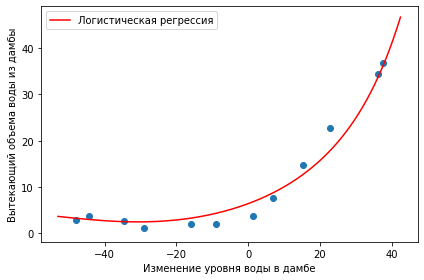

In [35]:
x = np.linspace(train_x.min()-5, train_x.max()+5, 1000)
x_poly = extend_values(scaler.transform(create_feature_map(x)))

# Построение разделяющей линии полученной модели.
pyplot.plot(x, x_poly.dot(thetas), label='Логистическая регрессия', color='r')

# Построение легенды графика.
pyplot.legend(loc='best')

# Построение точечной диаграммы разброса данных.
pyplot.scatter(train_x, train_y)

# Настройка координатных осей графика.
pyplot.xlabel('Изменение уровня воды в дамбе')
pyplot.ylabel('Вытекающий объема воды из дамбы')

# Настройка отображения.
pyplot.tight_layout()

# Отображение графика.
pyplot.show()

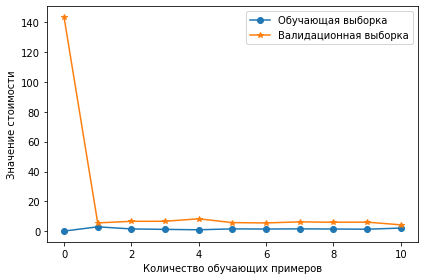

In [36]:
# Создание контейнеров для накопления значений стоимостей.
train_cost = np.zeros(train_y.shape[0])
valid_cost = np.zeros(train_y.shape[0])

# Запуск оптимизации математической модели.
for i in range(1, train_y.shape[0]):
    temp = fit(extend_values(train_norm)[0:i+1, :], train_y[0:i+1], l2=1.0)

    # Вычисление и сохранение стоимости на тестируемой и валидационной выборке.
    train_cost[i] = calc_cost(temp, extend_values(train_norm)[0:i+1, :], train_y[0:i+1])
    valid_cost[i] = calc_cost(temp, extend_values(valid_norm), valid_y)

# Построение процесса обучения математической модели.
draw_process(train_cost, valid_cost)

In [37]:
# Вычисление значения стоимости обученной математической модели.
print('Значение стоимости:', calc_cost(thetas, valid_norm, valid_y))

Значение стоимости: 4.260631693399616


<p lang="ru"><b>Пункт №12:&nbsp;</b>Сравнение разнообразных коэффициентов регуляризации для обучения математической модели. Параметр регуляризации уменьшает переопределение, что уменьшает дисперсию ваших оценочных параметров регрессии, однако он делает это за счет добавления смещения к исходной оценке. Увеличение лямбда приводит к меньшему переосмыслению признаков, но также к большей предвзятости.</p>

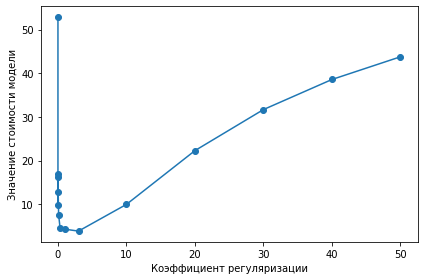

In [38]:
# Доступные коэффициенты регуляризации для сравнения.
l2_values = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 20, 30, 40, 50]

valid_error = [
    # Запуск оптимизации математической модели и вычисление значения стоимости.
    calc_cost(fit(train_norm, train_y, l2), valid_norm, valid_y)
    for l2 in l2_values
]

# Построение графика стоимостей модели при различных значениях регуляризации.
pyplot.plot(l2_values, valid_error, marker='o')

# Настройка координатных осей графика.
pyplot.xlabel('Коэффициент регуляризации')
pyplot.ylabel('Значение стоимости модели')

# Настройка отображения.
pyplot.tight_layout()

# Отображение графика.
pyplot.show()